In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442100110323_engineered.csv')
# buat df baru hanya READ_DATE dan KWH_EXP saja
df = df[['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss']]
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss
READ_DATE,,,,,,,,,,,
2019-01-01,1.704497,25.7,24.8,30.2,44.0,6.4,1008.9,25.7,96.0,12.9,7.5
2019-01-02,1.804380,26.0,24.1,29.2,21.0,5.4,1009.2,25.9,90.0,42.7,6.7
2019-01-03,1.606232,24.6,24.0,27.3,340.0,4.1,1010.3,24.9,94.0,0.5,0.1
2019-01-04,1.220510,26.2,23.0,29.8,340.0,6.9,1011.4,25.8,88.0,34.6,0.1
2019-01-05,0.980424,26.9,23.6,30.2,284.0,6.3,1011.7,26.7,88.0,2.1,3.2
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,64.703542,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4
2024-05-28,63.751474,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2
2024-05-29,68.610622,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7


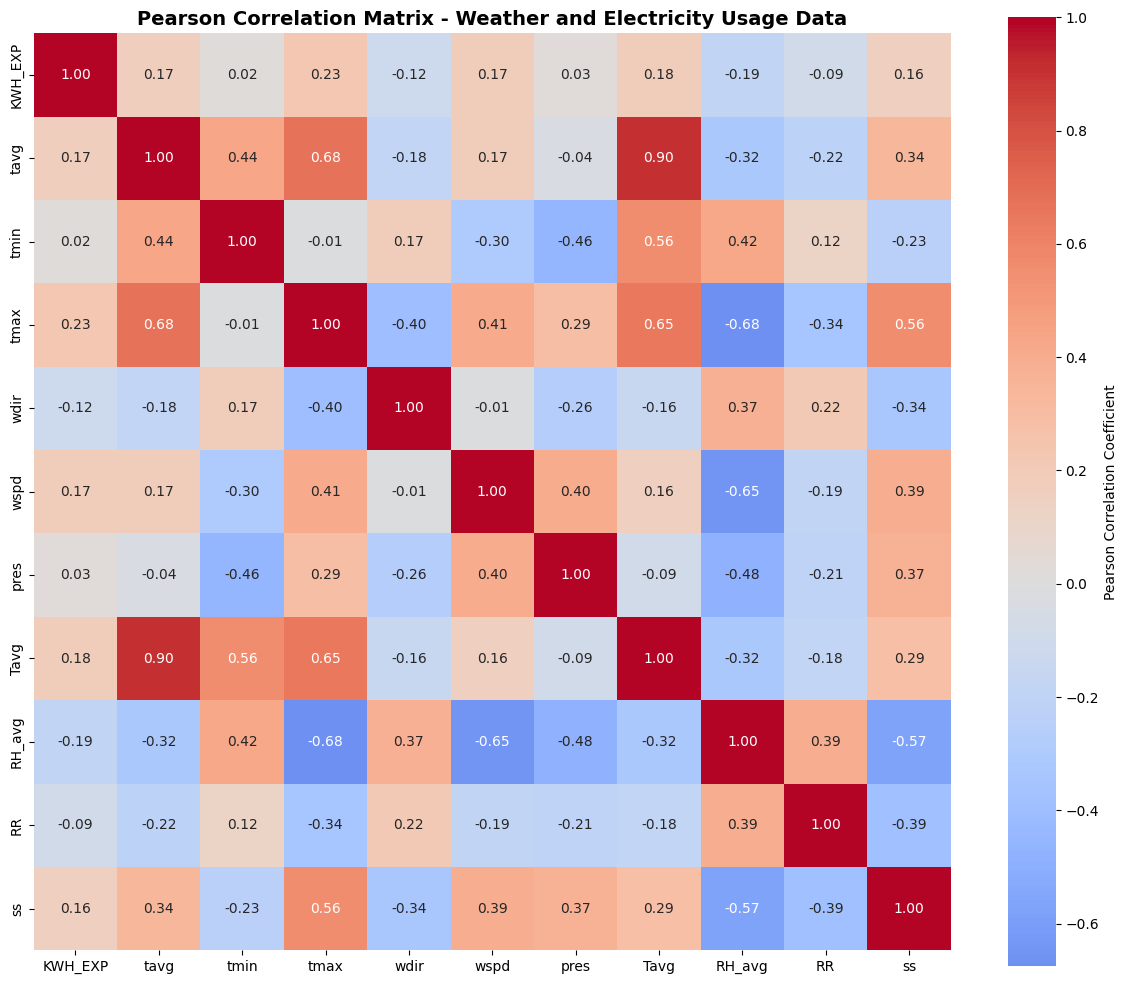

Correlation with KWH_EXP:
KWH_EXP    1.000000
tmax       0.229493
Tavg       0.177889
wspd       0.170018
tavg       0.165286
ss         0.156133
pres       0.026239
tmin       0.022221
RR        -0.089299
wdir      -0.115678
RH_avg    -0.188471
Name: KWH_EXP, dtype: float64


In [12]:
correlation_matrix = df.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,  # Tampilkan nilai korelasi
            cmap='coolwarm',  # Color map
            center=0,  # Pusat skala warna di 0
            square=True,  # Bentuk kotak
            fmt='.2f',  # Format angka 2 desimal
            cbar_kws={'label': 'Pearson Correlation Coefficient'})

plt.title('Pearson Correlation Matrix - Weather and Electricity Usage Data',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation with KWH_EXP:")
print(correlation_matrix['KWH_EXP'].sort_values(ascending=False))

In [16]:
df = df[['KWH_EXP', 'tmax', 'wspd', 'pres', 'Tavg', 'ss']]
df

,KWH_EXP,tmax,wspd,pres,Tavg,ss
READ_DATE,,,,,,
2019-01-01,1.704497,30.2,6.4,1008.9,25.7,7.5
2019-01-02,1.804380,29.2,5.4,1009.2,25.9,6.7
2019-01-03,1.606232,27.3,4.1,1010.3,24.9,0.1
2019-01-04,1.220510,29.8,6.9,1011.4,25.8,0.1
2019-01-05,0.980424,30.2,6.3,1011.7,26.7,3.2
...,...,...,...,...,...,...
2024-05-27,64.703542,34.0,9.9,1009.9,28.7,10.4
2024-05-28,63.751474,33.9,8.0,1009.4,28.2,8.2
2024-05-29,68.610622,33.0,7.7,1009.1,29.0,10.7


In [17]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE KWH_EXP	tavg	tmin	tmax	wdir	wspd	pres	Tavg	RH_avg	RR	ss
019-01-01	1.704497	25.7	24.8	30.2	44.0	6.4	1008.9	25.7	96.0	12.9	7.5
2019-01-02	1.804380	26.0	24.1	29.2	21.0	5.4	1009.2	25.9	90.0	42.7	6.7
2019-01-03	1.606232	24.6	24.0	27.3	340.0	4.1	1010.3	24.9	94.0	0.5	0.1
2019-01-04	1.220510	26.2	23.0	29.8	340.0	6.9	1011.4	25.8	88.0	34.6	0.1
2019-01-05	0.980424	26.9	23.6	30.2	284.0	6.3	1011.7	26.7	88.0	2.1	3.2
"""


train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [18]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [19]:
train_scaled_features

array([[-1.08680743, -1.55236723, -1.08460424, -0.22940841, -1.51036951,
        -0.17024642],
       [-1.07385209, -2.13049838, -1.53006888, -0.047088  , -1.32299254,
        -0.44476392],
       [-1.09955293, -3.22894758, -2.1091729 ,  0.62142017, -2.25987737,
        -2.70953335],
       ...,
       [-1.06980884, -1.55236723, -0.41640729, -0.41172882, -1.22930406,
        -0.03298767],
       [-1.07348505, -3.22894758,  0.87544015, -0.22940841, -2.25987737,
        -2.05755427],
       [-1.0627245 , -0.80079673,  4.26097137, -0.59404923,  0.6444656 ,
        -2.74384803]])

In [20]:
# # Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

In [21]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)



Training model with selected features and timesteps = 1
Epoch 29: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


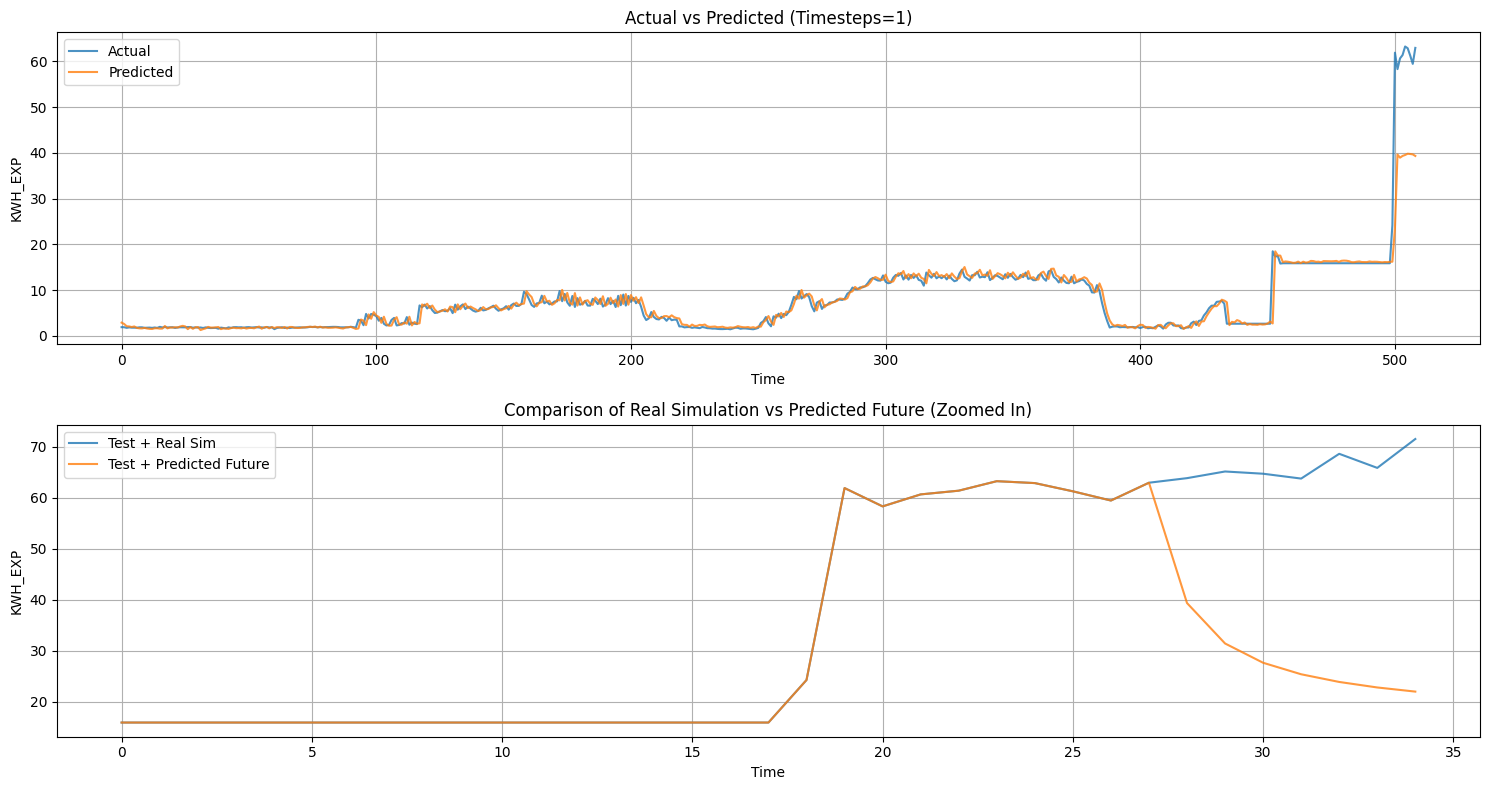


Metrics for timesteps=1:
MSE: 11.7302
R²: 0.8460
MAPE: 0.1325
MAE: 1.0625
Training time for timesteps = 1: 15.25 seconds

Training model with selected features and timesteps = 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


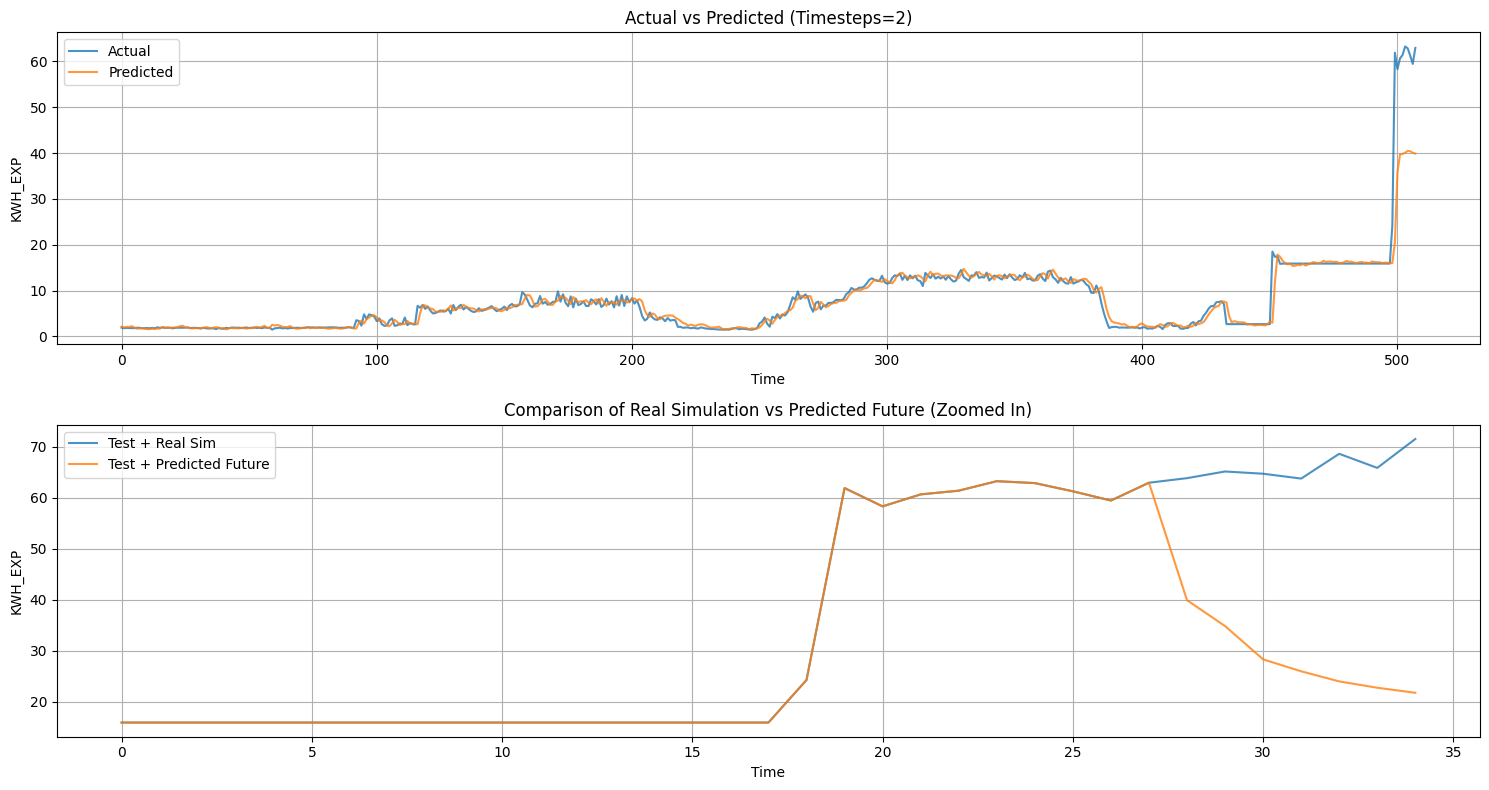


Metrics for timesteps=2:
MSE: 12.2221
R²: 0.8397
MAPE: 0.1410
MAE: 1.0739
Training time for timesteps = 2: 12.25 seconds

Training model with selected features and timesteps = 3
Epoch 19: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


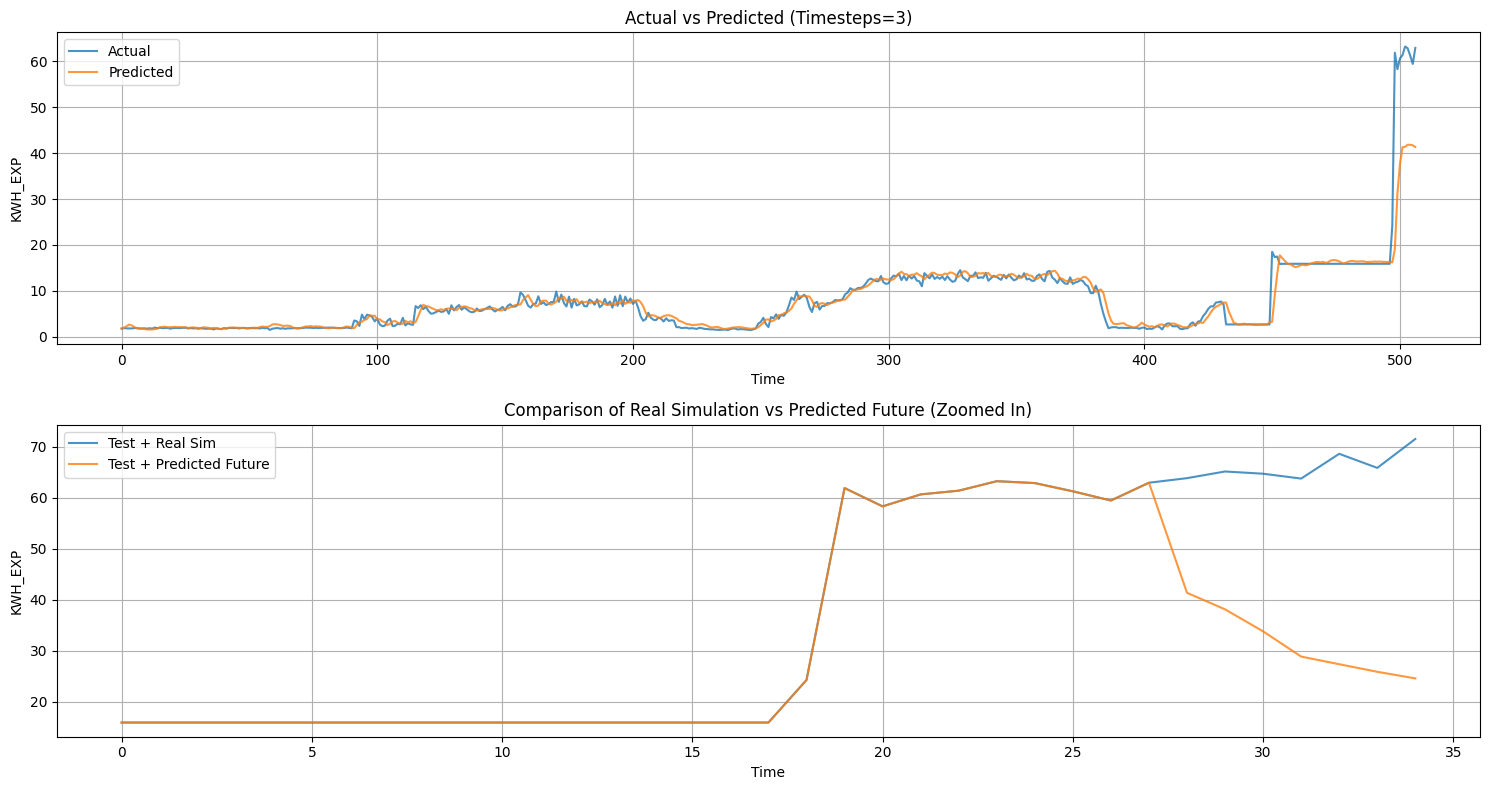


Metrics for timesteps=3:
MSE: 12.6153
R²: 0.8348
MAPE: 0.1598
MAE: 1.1460
Training time for timesteps = 3: 9.81 seconds

Training model with selected features and timesteps = 4
Epoch 45: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


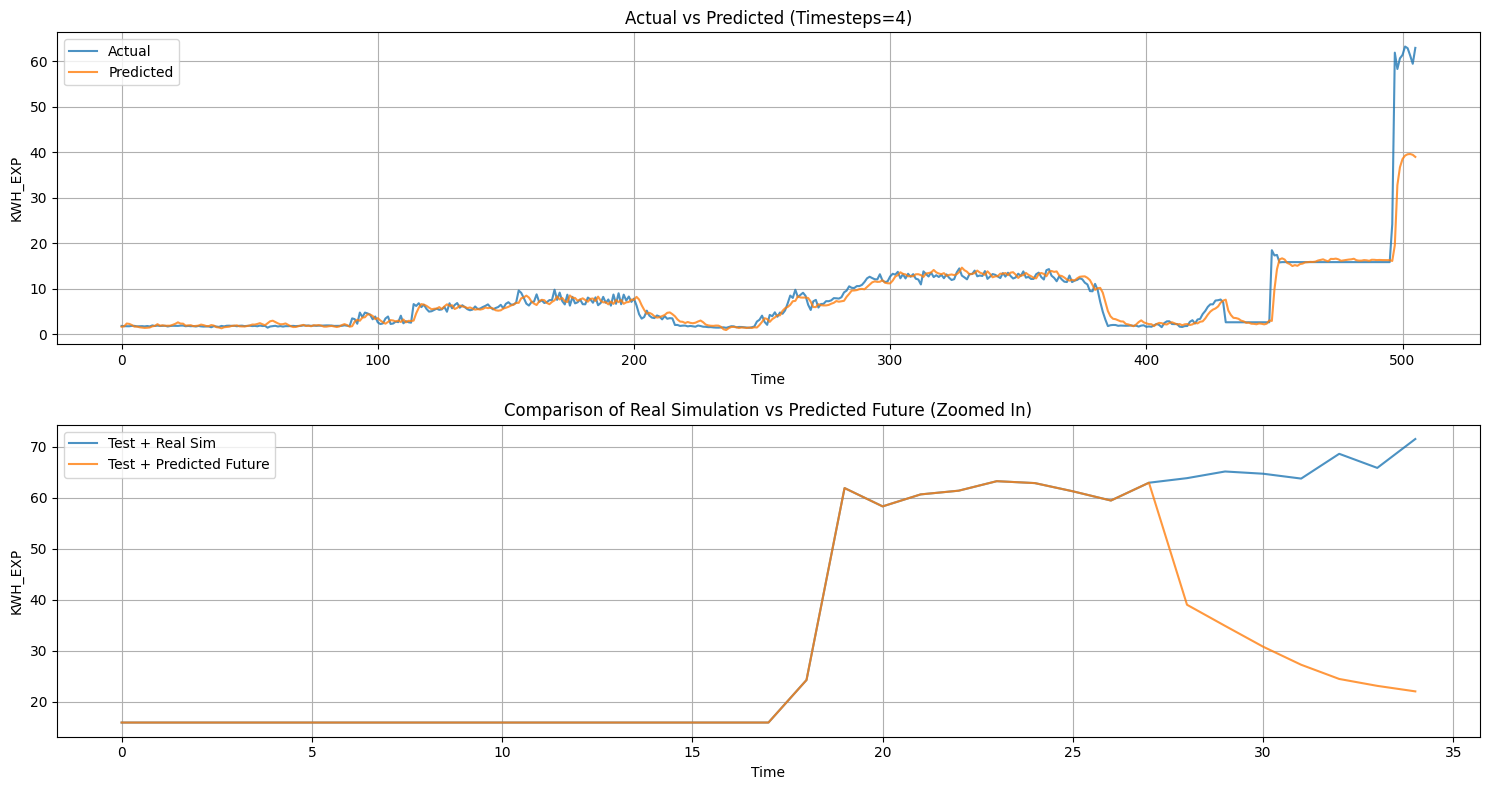


Metrics for timesteps=4:
MSE: 13.6693
R²: 0.8212
MAPE: 0.1651
MAE: 1.1980
Training time for timesteps = 4: 12.70 seconds

Training model with selected features and timesteps = 5
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


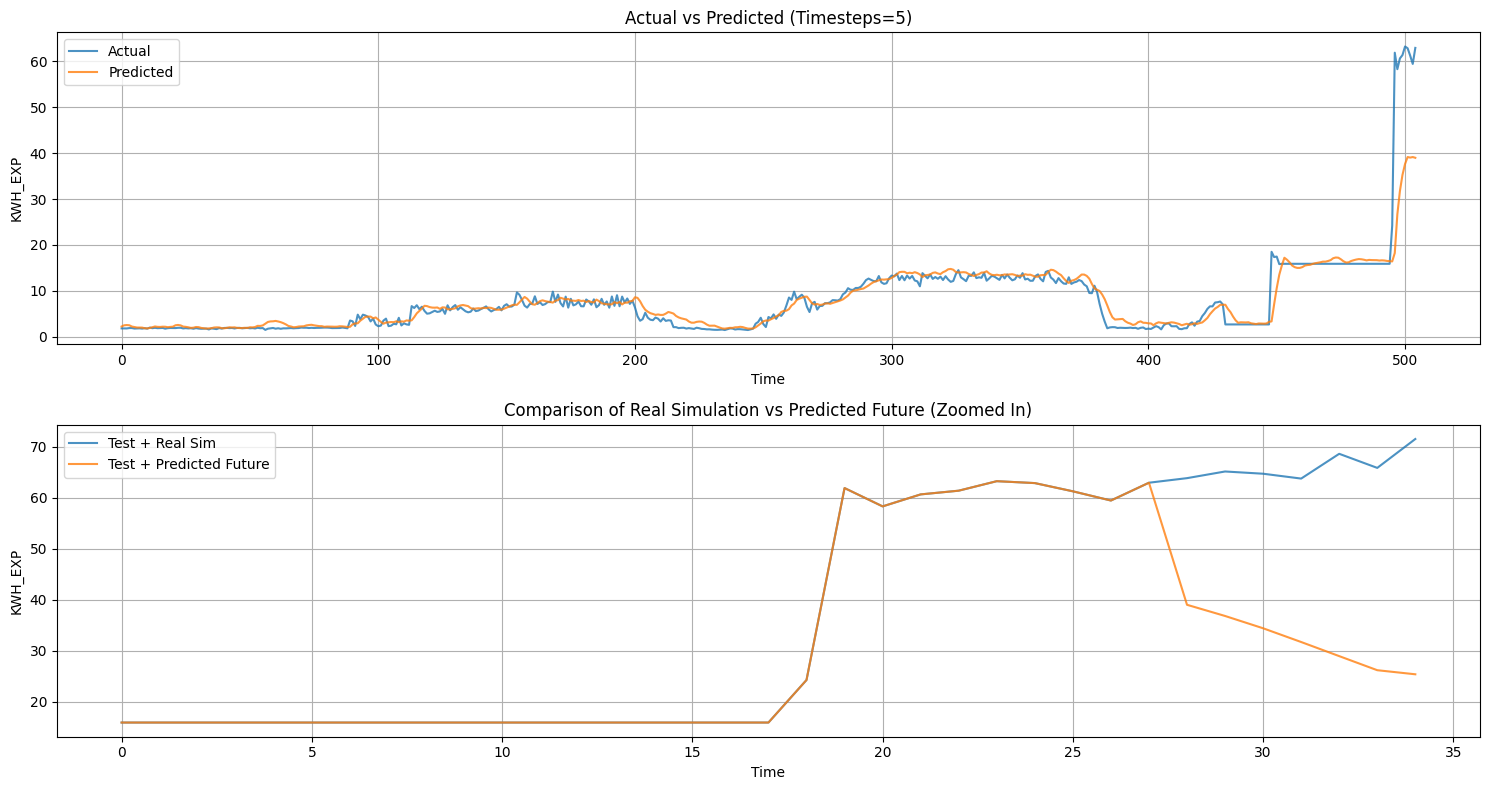


Metrics for timesteps=5:
MSE: 16.2840
R²: 0.7872
MAPE: 0.2274
MAE: 1.4084
Training time for timesteps = 5: 7.92 seconds

Training model with selected features and timesteps = 6
Epoch 29: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


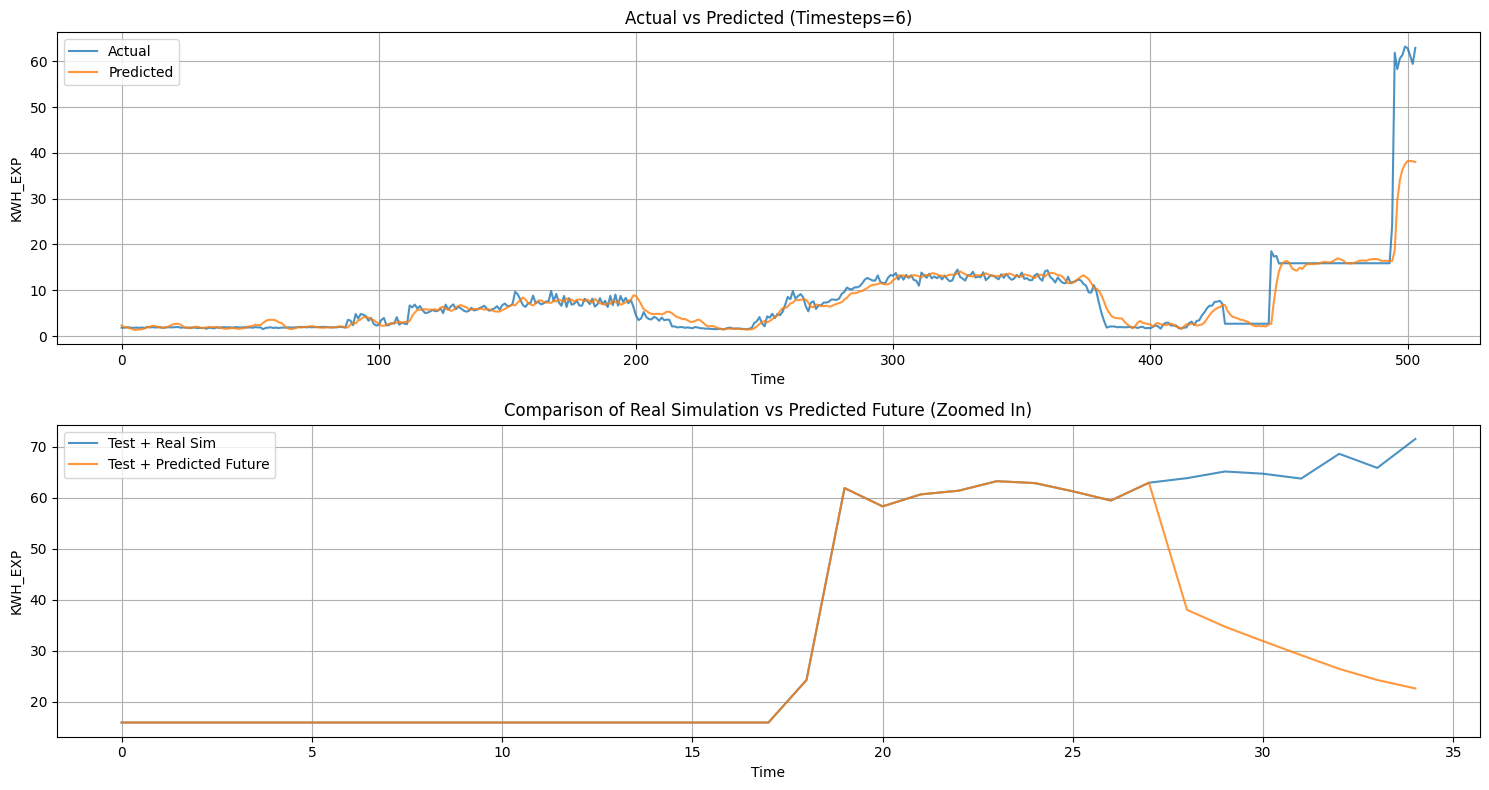


Metrics for timesteps=6:
MSE: 15.7780
R²: 0.7940
MAPE: 0.2053
MAE: 1.3555
Training time for timesteps = 6: 8.80 seconds

Training model with selected features and timesteps = 7
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


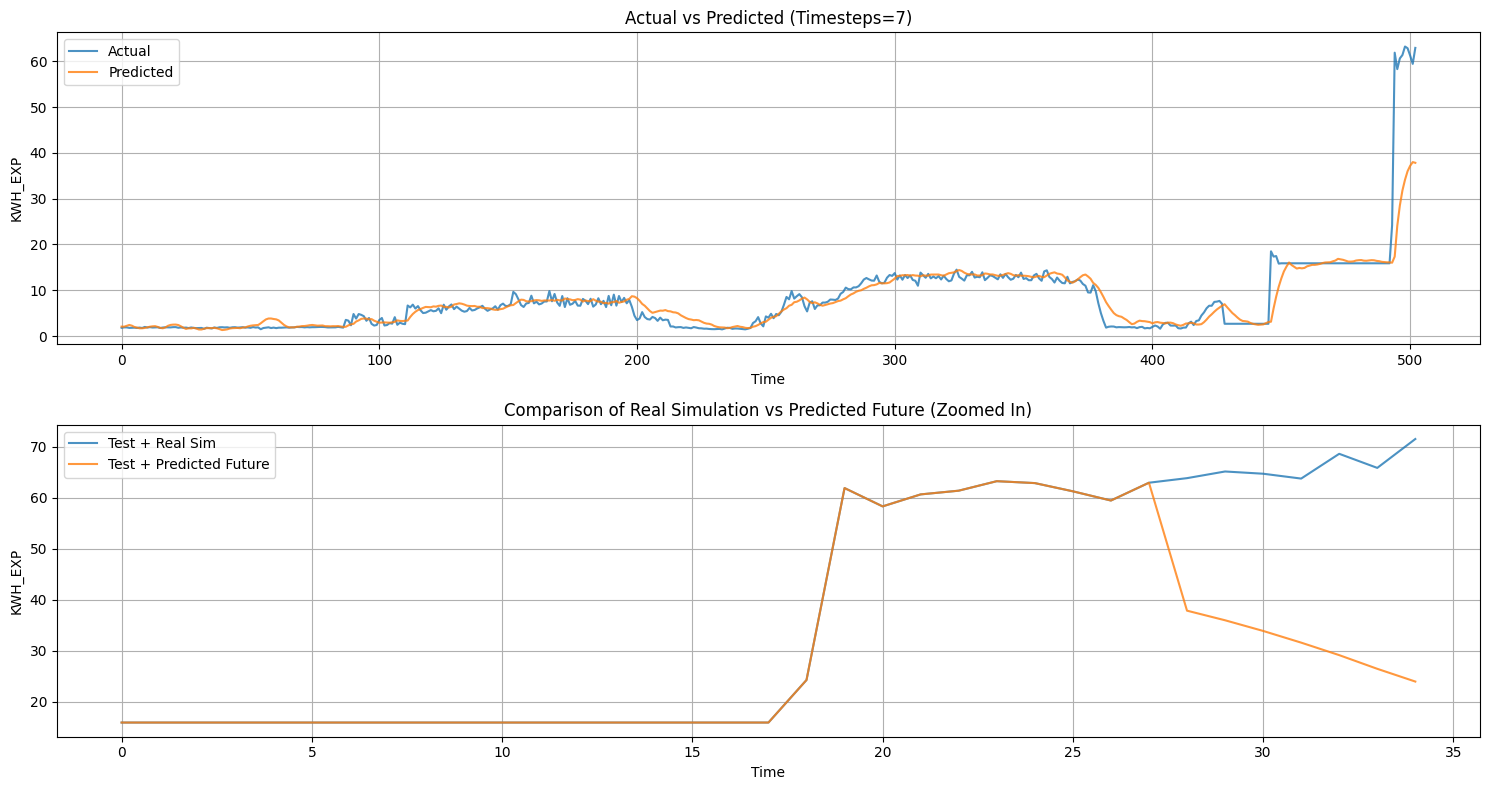


Metrics for timesteps=7:
MSE: 19.1830
R²: 0.7498
MAPE: 0.2518
MAE: 1.5326
Training time for timesteps = 7: 8.46 seconds
Total training execution time: 75.18 seconds


In [22]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:

    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [23]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [24]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 3, 4, 5, 6, 7]


Training model with selected features and timesteps = 1
Epoch 44: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


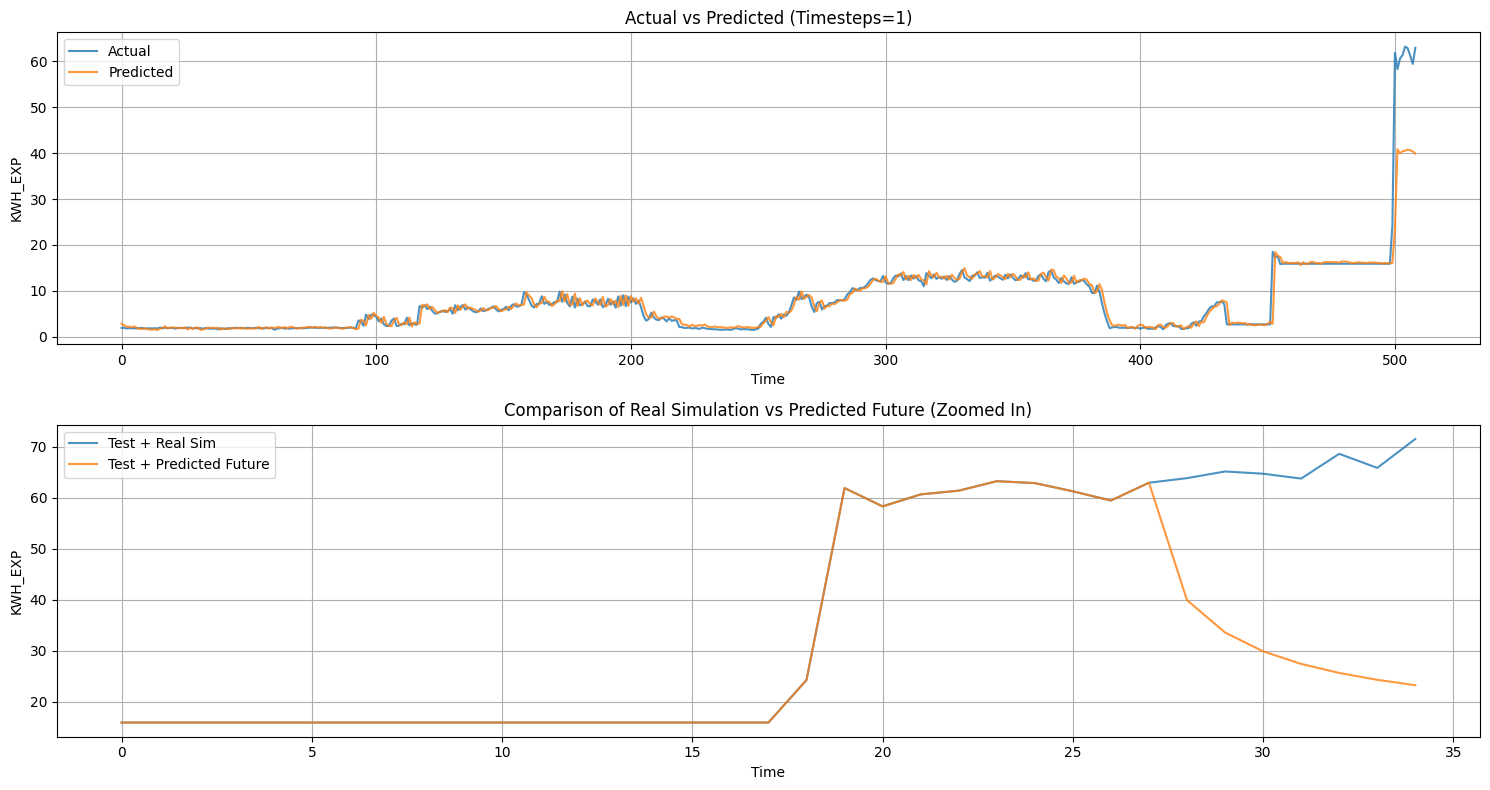


Metrics for timesteps=1:
MSE: 11.1103
R²: 0.8542
MAPE: 0.1379
MAE: 1.0464
Training time for timesteps = 1: 8.63 seconds

Training model with selected features and timesteps = 3
Epoch 24: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


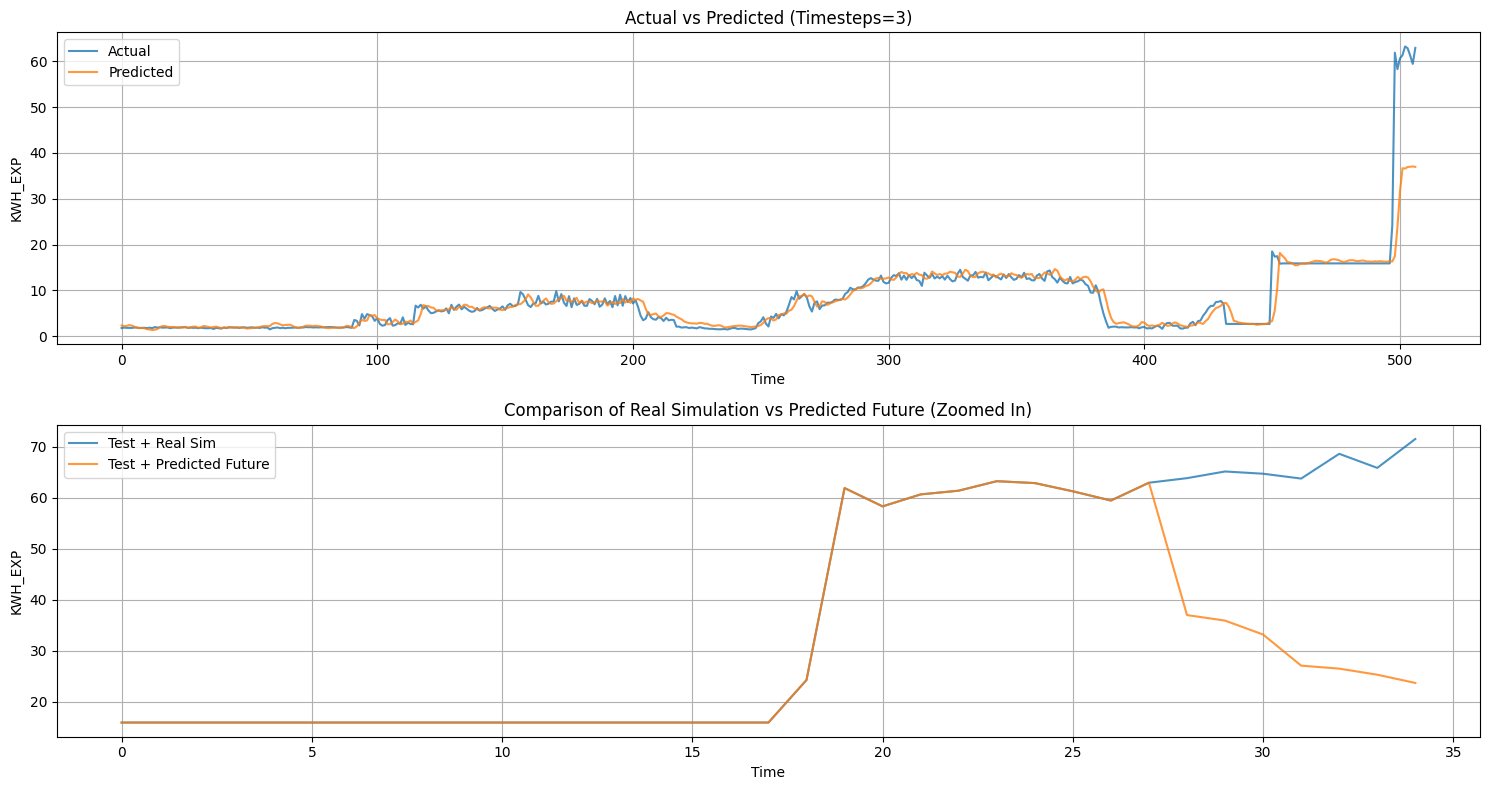


Metrics for timesteps=3:
MSE: 17.3370
R²: 0.7729
MAPE: 0.1846
MAE: 1.3119
Training time for timesteps = 3: 6.86 seconds

Training model with selected features and timesteps = 3
Epoch 24: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


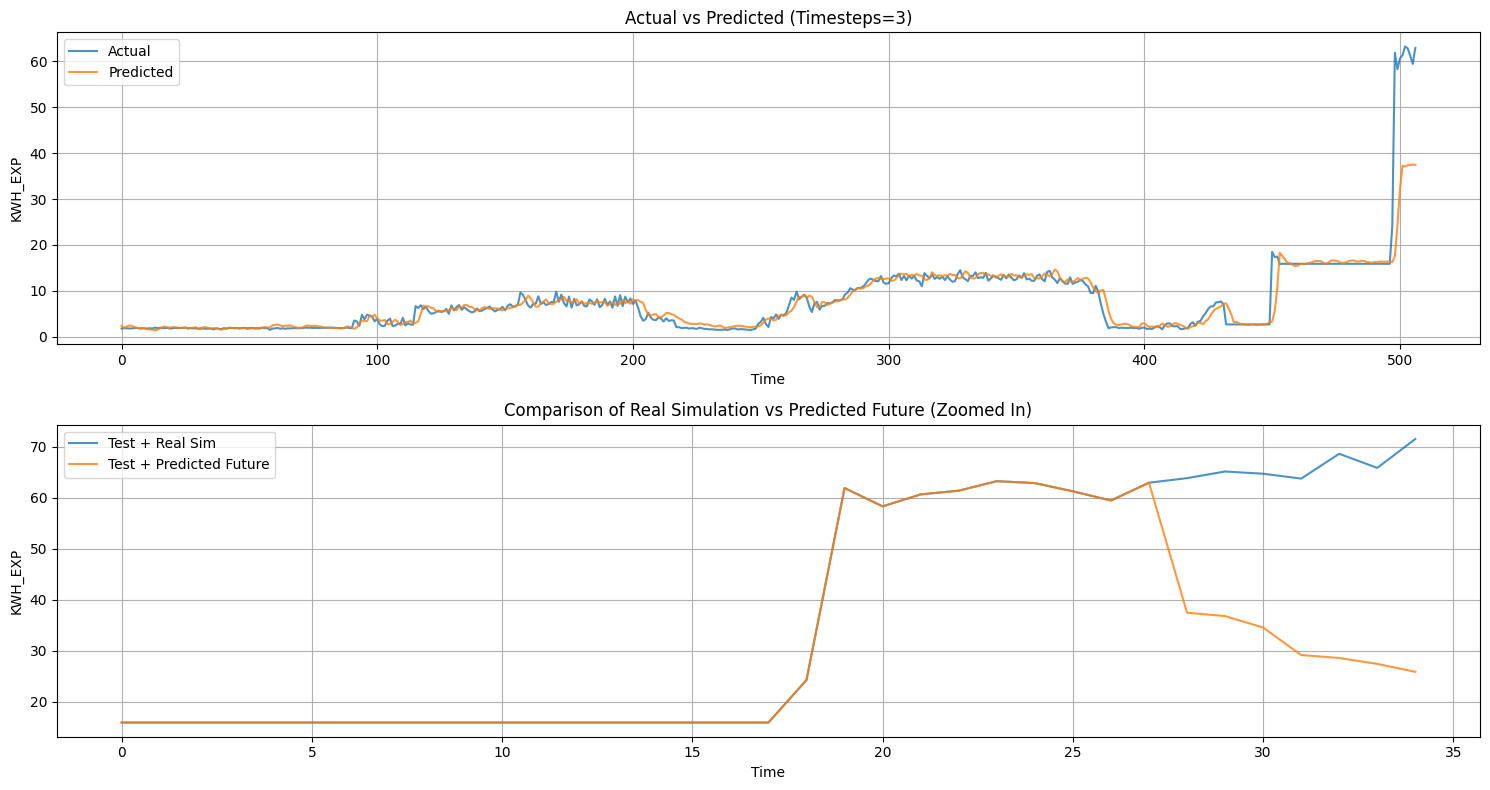


Metrics for timesteps=3:
MSE: 16.8747
R²: 0.7790
MAPE: 0.1799
MAE: 1.2828
Training time for timesteps = 3: 7.30 seconds

Training model with selected features and timesteps = 4
Epoch 17: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


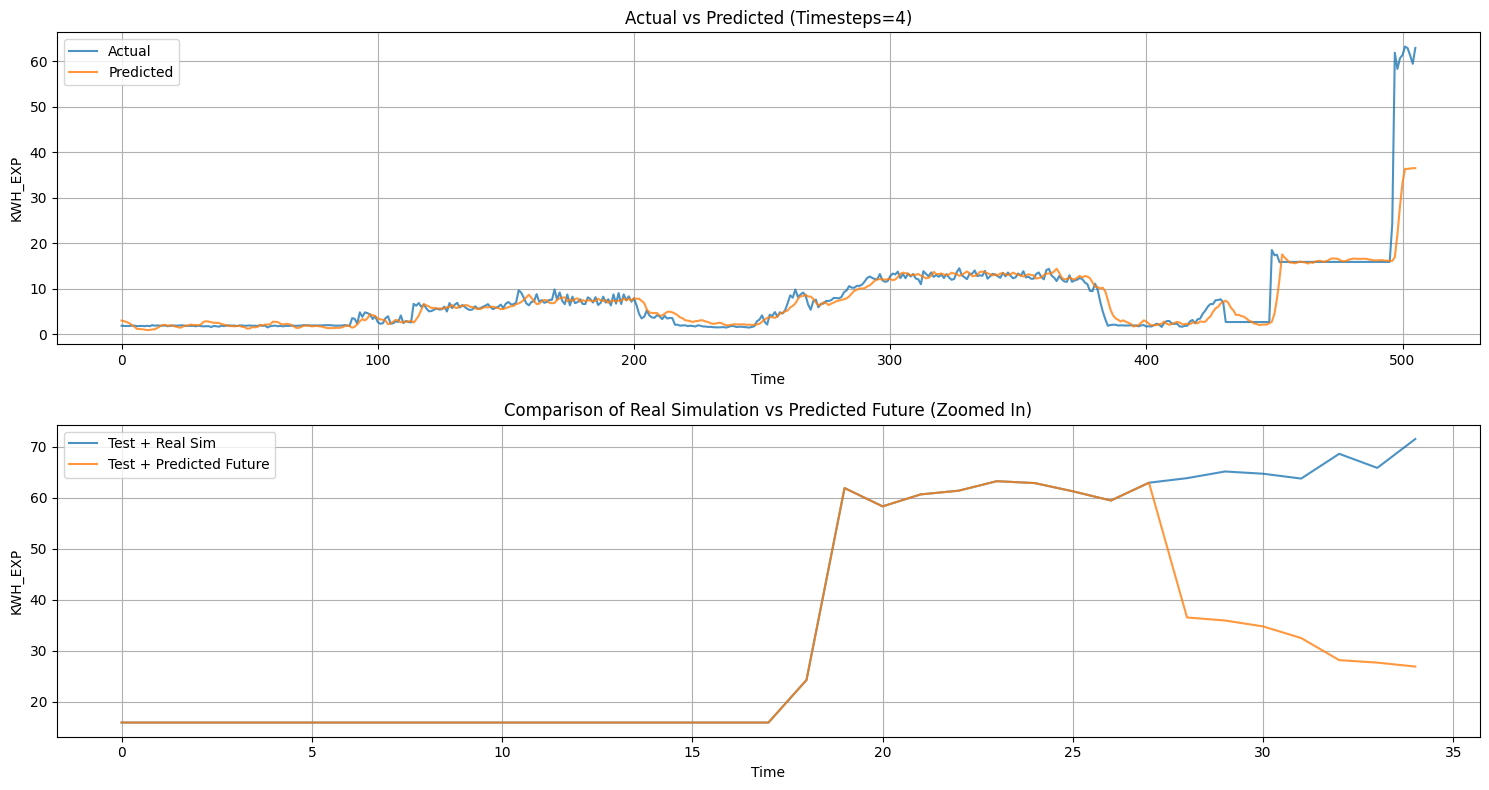


Metrics for timesteps=4:
MSE: 19.1566
R²: 0.7494
MAPE: 0.2143
MAE: 1.4078
Training time for timesteps = 4: 5.27 seconds

Training model with selected features and timesteps = 5
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


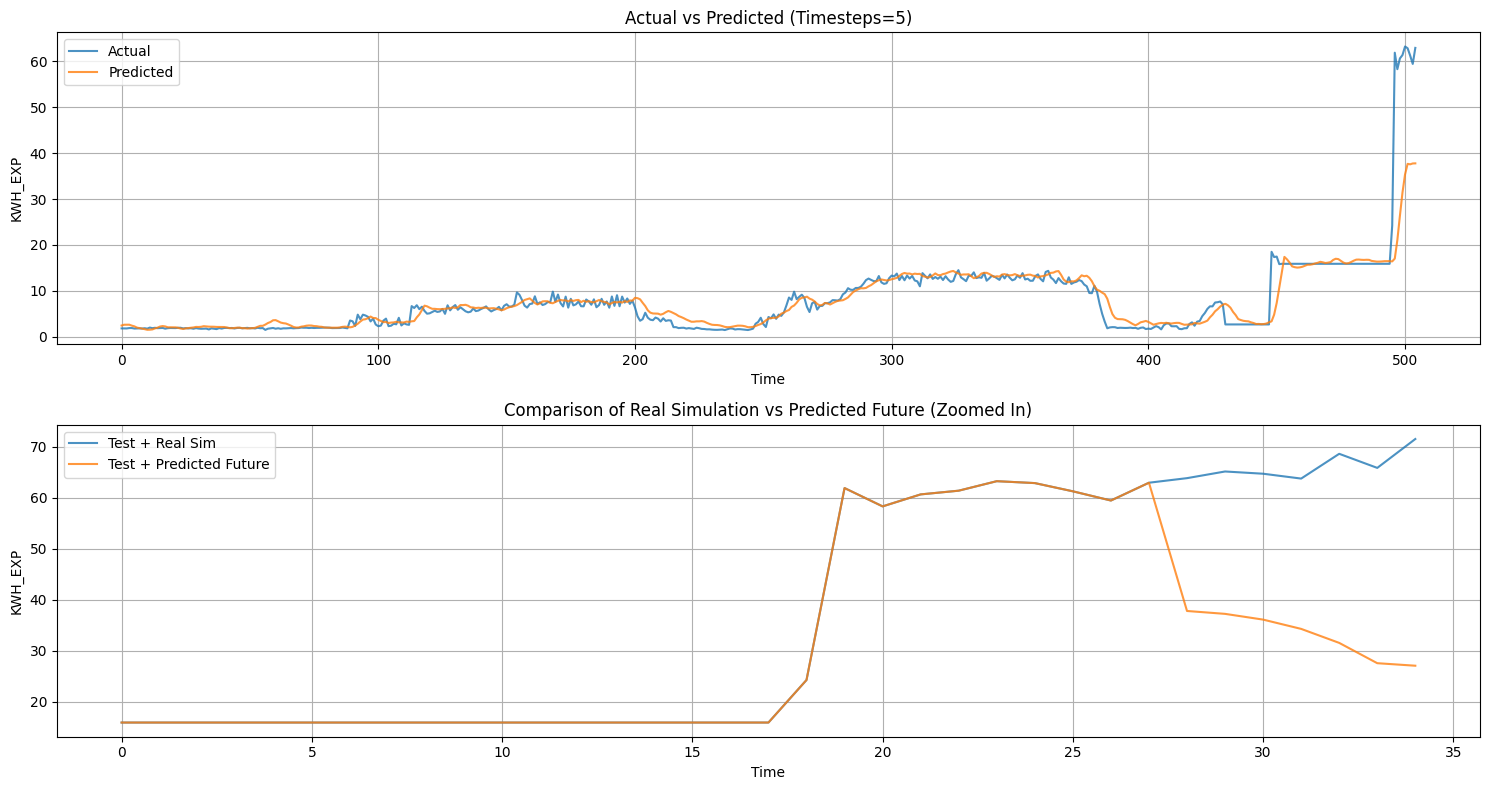


Metrics for timesteps=5:
MSE: 19.5715
R²: 0.7442
MAPE: 0.2479
MAE: 1.4996
Training time for timesteps = 5: 5.99 seconds

Training model with selected features and timesteps = 6
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


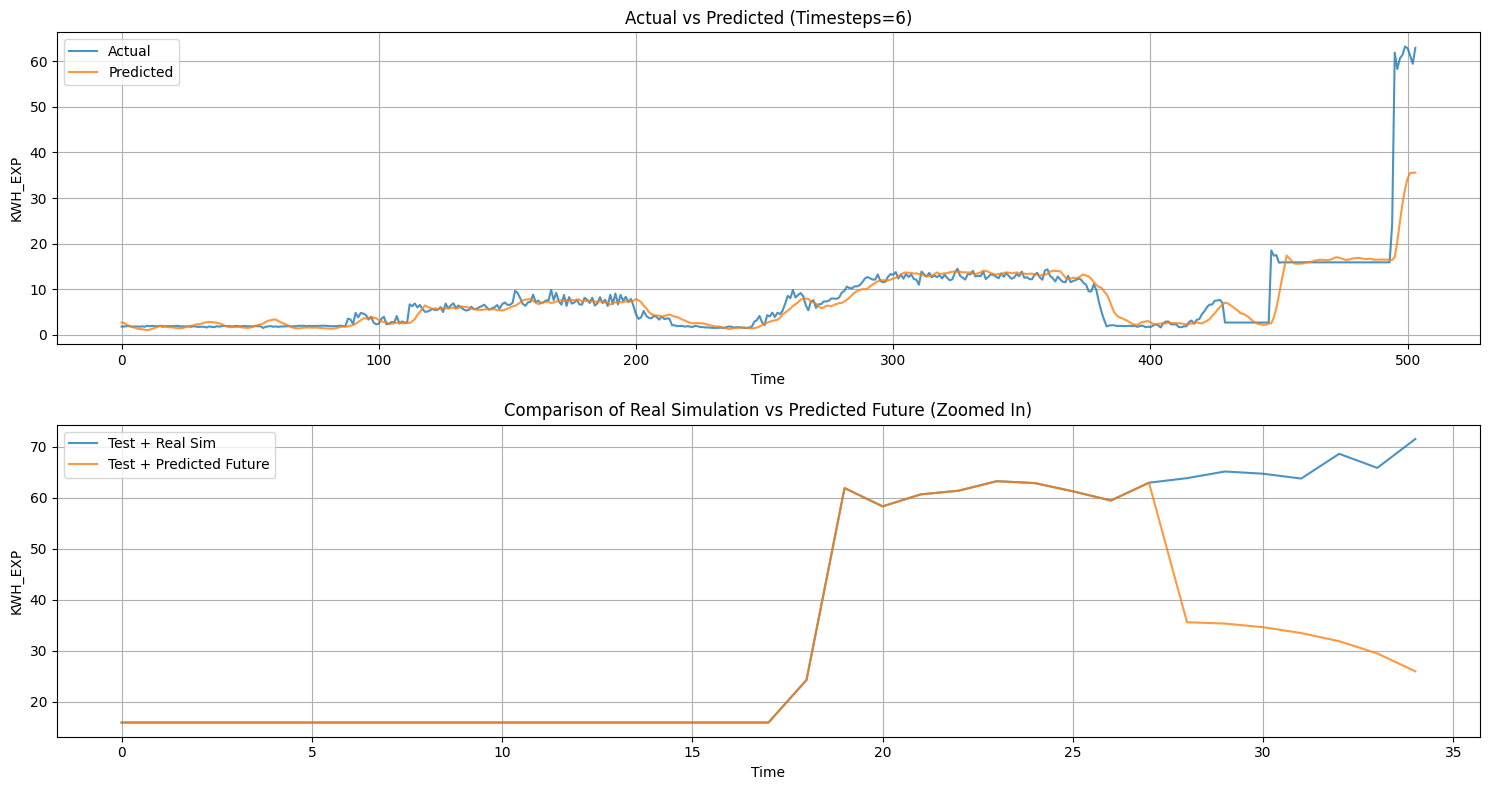


Metrics for timesteps=6:
MSE: 22.1057
R²: 0.7114
MAPE: 0.2432
MAE: 1.6078
Training time for timesteps = 6: 6.08 seconds

Training model with selected features and timesteps = 7
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


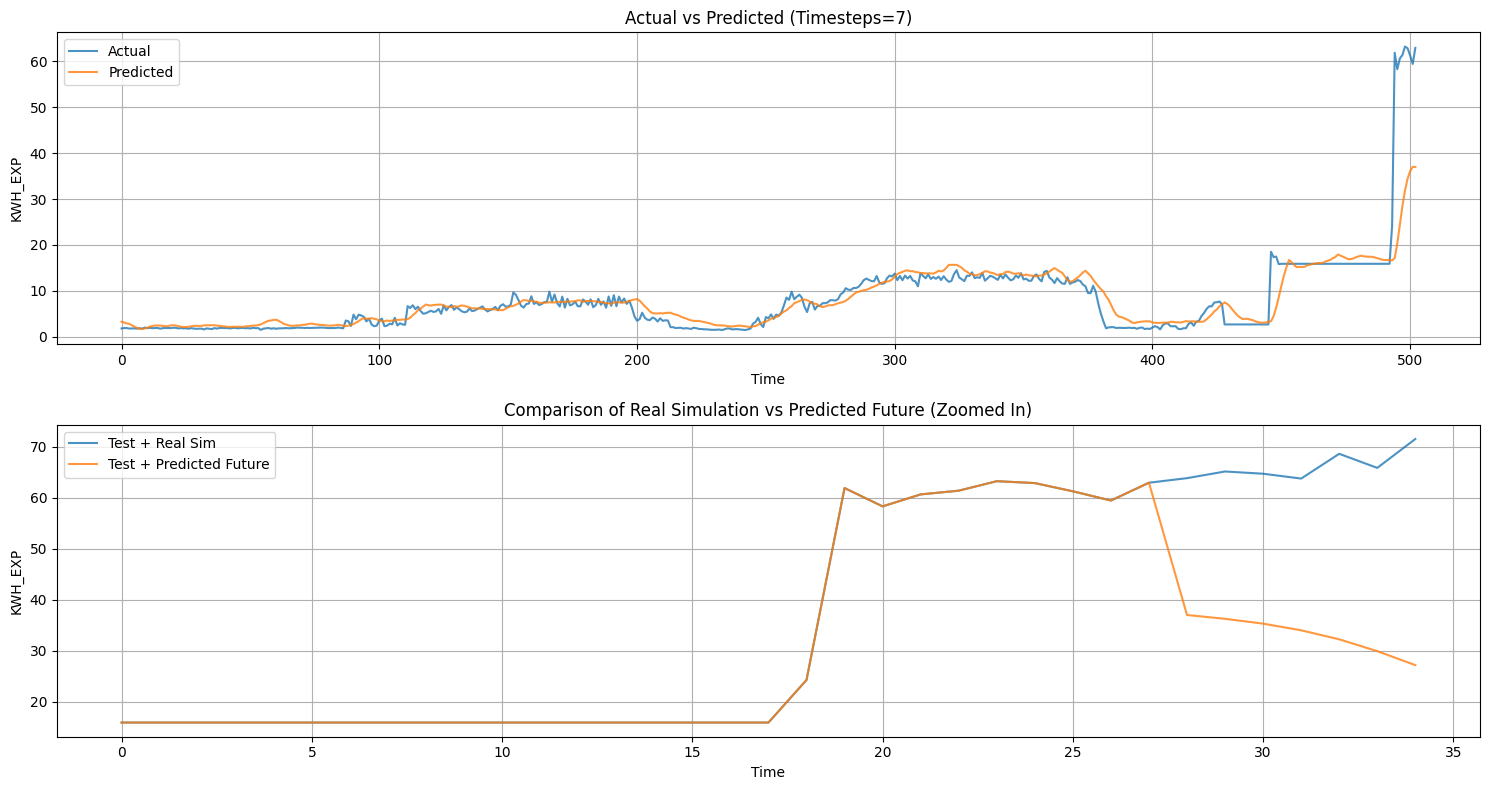


Metrics for timesteps=7:
MSE: 22.2808
R²: 0.7094
MAPE: 0.3175
MAE: 1.8049
Training time for timesteps = 7: 5.84 seconds
Total training execution time: 45.97 seconds


In [25]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")